In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

f = h5py.File('nyu_depth_v2_labeled.mat','r')
data = f.get('images')
data = np.array(data).transpose() # For converting to a NumPy array
depth = f.get('depths')
depth = np.array(depth).transpose()

In [2]:
data, depth = np.moveaxis(data,-1,0), np.moveaxis(depth,-1,0)
data, depth = data[:,80:400,100:500,:],depth[:,80:400,100:500]
data, depth = data/255, depth/depth.max()
depth = np.reshape(depth,(depth.shape[0],depth.shape[1],depth.shape[2],1))
print(data.shape)
print(depth.shape)


(1449, 320, 400, 3)
(1449, 320, 400, 1)


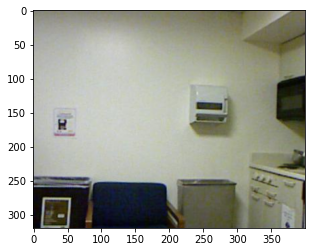

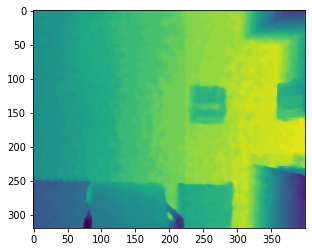

In [3]:
imgplot = plt.imshow(data[0,:,:,:])
plt.show()
imgplot = plt.imshow(depth[0,:,:])
plt.show()


In [4]:
ind = np.random.choice(range(data.shape[0]), size=(1449,), replace=False)
reduced_data = data[ind,:,:,:]
reduced_depths = depth[ind,:,:]
reduced_data.shape


(1449, 320, 400, 3)

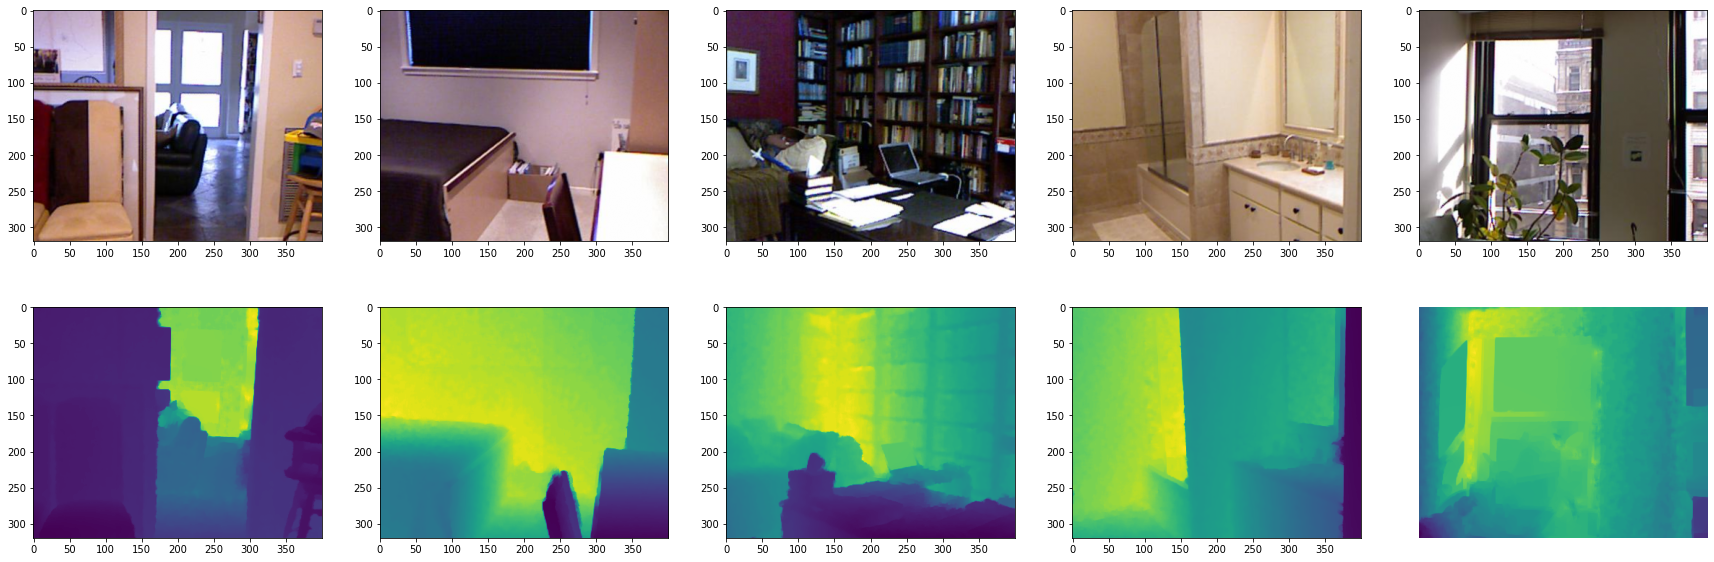

In [5]:
choice = np.random.choice(range(reduced_data.shape[0]), size=(1200,), replace=False)    
ind = np.zeros(reduced_data.shape[0], dtype=bool)
ind[choice] = True
rest = ~ind

x_train, y_train = reduced_data[ind,:,:,:],reduced_depths[ind,:,:]
x_test, y_test = reduced_data[rest,:,:,:],reduced_depths[rest,:,:]

f, ax = plt.subplots(2,5,figsize=(30, 10))
a = 0
for i in range(5):
  
  ax[0,a].imshow(x_train[i,:,:,:])
  ax[1,a].imshow(y_train[i,:,:])
  plt.axis("off")
  a+=1


In [6]:
print('x_train shape: ',x_train.shape,'/ x_test shape: ',x_test.shape)
print('y_train shape: ',y_train.shape,'/ y_test shape: ',y_test.shape)


x_train shape:  (1200, 320, 400, 3) / x_test shape:  (249, 320, 400, 3)
y_train shape:  (1200, 320, 400, 1) / y_test shape:  (249, 320, 400, 1)


In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Reshape, Conv2DTranspose, LeakyReLU,Activation,UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


#Hyperparameters 
H,W,C = 320,400,1
latent_dim = 256
epoch = 20
batch_size=8
lr = 0.01

inputs = Input(shape=(H,W,C))
x = inputs

########### ENCODER ####################
# Layer 1 
x = Conv2D(16,(3,3),padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

# Layer 2
x = Conv2D(16,(3,3),padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

# Layer 3
x = Conv2D(32,(3,3),padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)

# Layer 4
x = Conv2D(32,(3,3),padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
# Layer 5
x = Conv2D(64,(3,3),padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)
# Layer 6
x = Conv2D(64,(3,3),padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
###############################################
############### DECODER #######################
# Layer 7
x = Conv2DTranspose(64,(3,3),strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

# Layer 8
x = Conv2DTranspose(64,(3,3),strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

# Layer 9
x = Conv2DTranspose(32,(3,3),strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

# Layer 10
x = Conv2DTranspose(32,(3,3),strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

# Layer 11
x = Conv2DTranspose(16,(3,3),strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

# Layer 12
x = Conv2DTranspose(16,(3,3),strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2D(1,(3,3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation("sigmoid")(x)


out = x

autoencoders = Model(inputs,out)
autoencoders.compile(optimizer = Adam(lr), loss="mse")
autoencoders.summary(line_length=150)


Model: "model"
______________________________________________________________________________________________________________________________________________________
 Layer (type)                                                      Output Shape                                                Param #                
 input_1 (InputLayer)                                              [(None, 320, 400, 1)]                                       0                      
                                                                                                                                                      
 conv2d (Conv2D)                                                   (None, 320, 400, 16)                                        160                    
                                                                                                                                                      
 batch_normalization (BatchNormalization)                          (None, 320, 

In [8]:
history = autoencoders.fit(y_train,y_train,epochs=5,batch_size=batch_size,validation_split=0.1)

Epoch 1/5
135/135 [==============================] - 815s 6s/step - loss: 0.0130 - val_loss: 0.0062
Epoch 2/5
135/135 [==============================] - 588s 4s/step - loss: 0.0041 - val_loss: 0.0430
Epoch 3/5
135/135 [==============================] - 518s 4s/step - loss: 0.0025 - val_loss: 0.0072
Epoch 4/5
135/135 [==============================] - 512s 4s/step - loss: 0.0025 - val_loss: 0.0034
Epoch 5/5
135/135 [==============================] - 537s 4s/step - loss: 0.0023 - val_loss: 0.0019


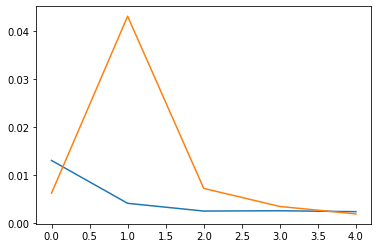

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [10]:
out_pre = autoencoders.predict([y_test])
out_pre.shape

8/8 [==============================] - 31s 4s/step


(249, 320, 400, 1)

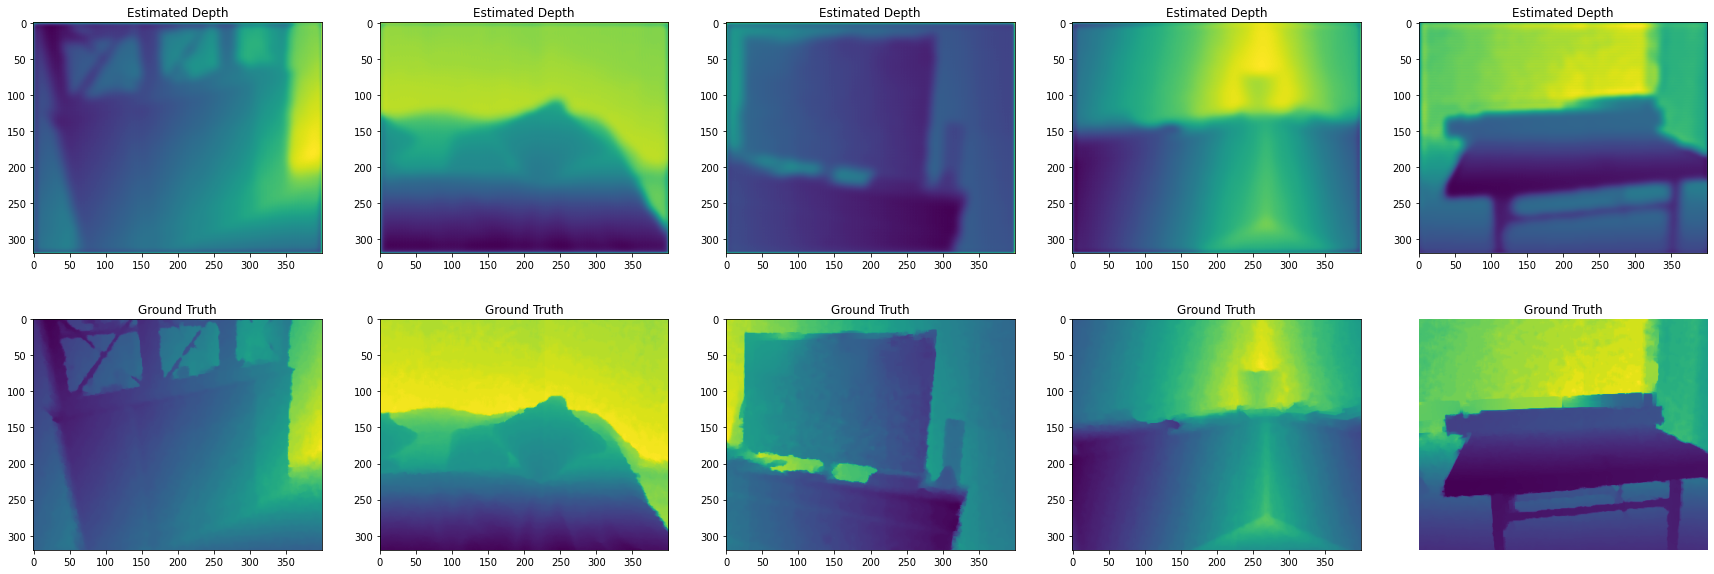

In [14]:
f, ax = plt.subplots(2,5,figsize=(30, 10))
a = 0
for i in range(5):
  
  ax[0,a].imshow(out_pre[i])
  ax[0,a].set_title('Estimated Depth')
  ax[1,a].imshow(y_test[i])
  ax[1,a].set_title('Ground Truth')

  plt.axis("off")
  a+=1